### Experiment 0


The objective with this experiment is to test the pipeline devloped.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import datetime
import os
import numpy as np
import tensorflow as tf
import keras
import sklearn.model_selection as sk
import copy
from PIL import Image as IM
from keras.callbacks import TensorBoard
import cv2
import json
import pathlib
from glob import glob

Using TensorFlow backend.


In [120]:
## import helpers
from helpers import data_loaders as dls
from helpers import pointcloud as pc
from helpers.viz import plot, plot_history
from helpers.logger import Logger

In [3]:
import lodnn

In [4]:
PATH = '../' # path of the repo.
_NAME = 'experiment0' # name of experiment
!ls $PATH

dataset  nbs  README.md  TODO


In [5]:
_EXP, _LOG, _TMP, _MODEL, _RES = dls.create_dir_struct(PATH, _NAME)
logger = Logger('EXP0', _LOG + 'experiment0.log')
logger.debug('Logger EXP0 int')
!ls $_EXP

log  result  tmp


In [6]:
# get dataset
train_set, valid_set, test_set = dls.get_dataset(PATH, is_training=True)

In [7]:
z_vals = dls.process_pc(train_set["pc"] + valid_set["pc"], lambda x: x[:, 2])
z_vals = np.concatenate(z_vals)
HEIGHT_MIN, HEIGHT_MAX = np.min(z_vals), np.max(z_vals)
print("Height ranges from {} to {}".format(HEIGHT_MIN, HEIGHT_MAX))
del z_vals

Height ranges from -30.21500015258789 to 2.9130001068115234


In [8]:
def preprocess(points):
    global HEIGHT_MIN, HEIGHT_MAX
    points = pc.filter_points(points, side_range=(-10, 10), fwd_range=(6, 46))
    z = points[:, 2]
    z_min, z_max = HEIGHT_MIN, HEIGHT_MAX
    z = (z - z_min)/(z_max - z_min)
    points[:, 2] = z
    return points

In [10]:
f_count = dls.process_pc(train_set["pc"] + valid_set["pc"],
                       lambda x: lodnn.get_features(preprocess(x))[:,:,0])

f_count = np.concatenate(f_count)
COUNT_MIN, COUNT_MAX = 0, np.max(f_count)
print("Count varies from {} to {}".format(COUNT_MIN, COUNT_MAX))
del f_count

Count varies from 0 to 122.0


In [43]:
def _get_features(points):
    global COUNT_MAX
    f = lodnn.get_features(preprocess(points))
    f[:, :, 0] = f[:, :, 0] / COUNT_MAX
    return f

In [108]:
f_train = dls.process_pc(train_set["pc"][0:5], lambda x: _get_features(x))
f_valid = dls.process_pc(valid_set["pc"][0:2], lambda x: _get_features(x))
f_test = dls.process_pc(test_set["pc"][0:2], lambda x: _get_features(x))

In [109]:
def kitti_gt(img):
    road = img[:, :, 0] / 255 # Road is encoded as 255 in the B plane
    non_road = 1 - road # TODO: can we do this in training time?
    return np.dstack([road, non_road])

In [110]:
gt_train = dls.process_img(train_set["gt_bev"][0:5], func=lambda x: kitti_gt(x))
gt_valid = dls.process_img(valid_set["gt_bev"][0:2], func=lambda x: kitti_gt(x))
gt_test = dls.process_img(train_set["gt_bev"][0:2], func=lambda x: kitti_gt(x))

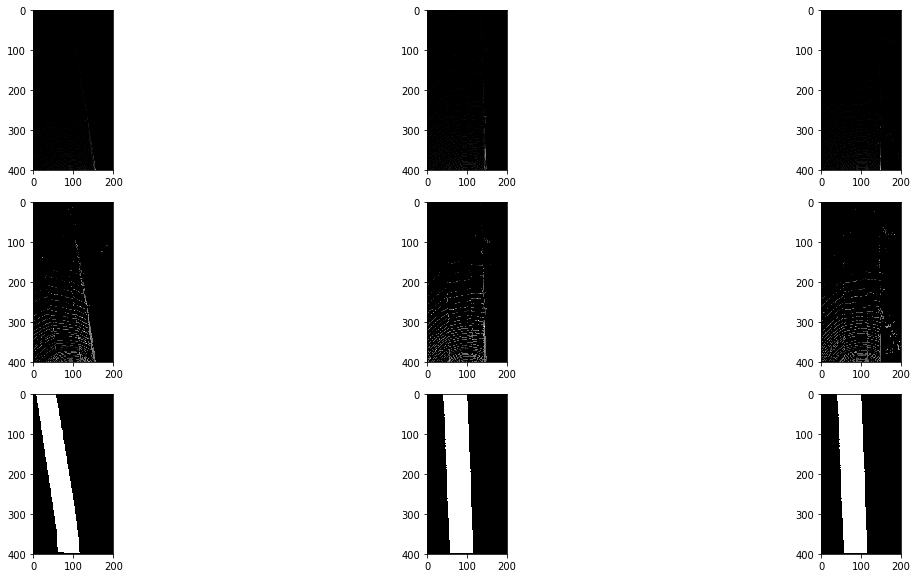

In [54]:
_ = plot([[f_train[0][:,:,0], f_train[1][:,:,0],  f_train[2][:,:,0]],
      [f_train[0][:,:,1], f_train[1][:,:,1],  f_train[2][:,:,1]],
      [gt_train[0][:,:,0], gt_train[1][:,:,0], gt_train[1][:,:,0]]
     ])

In [55]:
# Let the training begin

In [56]:
model = lodnn.get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 400, 200, 32)      1760      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 400, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 100, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 100, 128)     36992     
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 200, 100, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 100, 128)     147584    
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 200, 100, 128)     0         
__________

In [83]:
def get_unique_id():
    return datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')

In [84]:
run_id = get_unique_id()
run_id

'2019_07_07_23_19'

In [85]:
# training func - define a training func to do training
# unique identifier
# callbacks
    # save the best model
    # model saving - save models after specific epochs
    # tensorboard - save the history for analysis
    # 

In [86]:
!ls $_EXP

log  result  tmp


In [118]:
def get_basic_callbacks(exp_path, run_id):
    # tensorboard
    # to visualise `tensorboard --logdir="./path_to_log_dir" --port 6006`
    log_path = "{}/log/{}/".format(exp_path, run_id)
    os.makedirs(log_path, exist_ok=True)
    tensorboard = TensorBoard(log_dir="{}/{}".format(log_path, time()))
    # save best model
    best_model_path = "{}/result/model/{}/best_model.h5".format(exp_path, run_id) #? .hd5
    os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
    save_the_best = keras.callbacks.ModelCheckpoint(filepath=best_model_path,
                                                    verbose=1, save_best_only=True)
    # save models after few epochs
    epoch_save_path = "{}/result/model/{}/*.h5".format(exp_path, run_id)
    save_after_epoch = keras.callbacks.ModelCheckpoint(filepath=epoch_save_path.replace('*', 'e{epoch:02d}-val_acc{val_acc:.2f}'),
                                                       monitor='val_acc', verbose=1, period = 1)
    return [tensorboard, save_the_best, save_after_epoch]

In [116]:
callbacks = get_basic_callbacks(_EXP, run_id)

In [103]:
# model.get_config()

In [111]:
training_config = {
    "loss_function" : "binary_crossentropy",
    "learning_rate" : 1e-4,
    "batch_size"    : 1,
    "epochs"        : 3,
    "optimizer"     : "keras.optimizers.Adam"
}

In [112]:
optimizer = eval(training_config["optimizer"])(lr=training_config["learning_rate"])
optimizer

In [113]:
model.compile(loss=training_config["loss_function"],
              optimizer=optimizer,
              metrics=['accuracy'])

In [106]:
np.array(f_train).shape

(10, 400, 200, 6)

In [117]:
# model.fit(X_train, Y_train, validation_data=(X_test, Y_test))
m_history = model.fit(x=np.array(f_train),
                      y=np.array(gt_train),
                      batch_size=training_config["batch_size"],
                      epochs=training_config["epochs"],
                      verbose=1,
                      callbacks=callbacks,
                      validation_data=(np.array(f_valid), np.array(gt_valid))) 

Train on 5 samples, validate on 2 samples
Epoch 1/3
4/5 [=======================>......] - ETA: 6s - loss: 0.5881 - acc: 0.6789 Epoch 00001: val_loss improved from inf to 0.60116, saving model to ..//nbs/output/experiment0/result/model/2019_07_07_23_19/best_model.h5
Epoch 00001: saving model to ..//nbs/output/experiment0/result/model/2019_07_07_23_19/-01-0.62.h5
5/5 [==============================] - 36s 7s/step - loss: 0.5803 - acc: 0.6924 - val_loss: 0.6012 - val_acc: 0.6238
Epoch 2/3
4/5 [=======================>......] - ETA: 6s - loss: 0.5299 - acc: 0.6934 Epoch 00002: val_loss improved from 0.60116 to 0.53707, saving model to ..//nbs/output/experiment0/result/model/2019_07_07_23_19/best_model.h5
Epoch 00002: saving model to ..//nbs/output/experiment0/result/model/2019_07_07_23_19/-02-0.69.h5
5/5 [==============================] - 38s 8s/step - loss: 0.5166 - acc: 0.7020 - val_loss: 0.5371 - val_acc: 0.6881
Epoch 3/3
4/5 [=======================>......] - ETA: 6s - loss: 0.4199 - 

In [119]:
model.save("{}/result/model/{}/final_model.h5".format(_EXP, run_id))

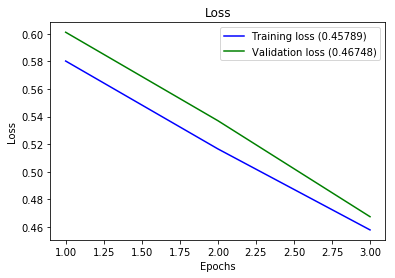

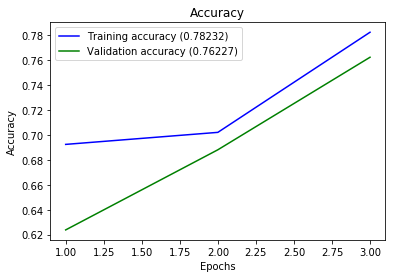

In [121]:
plot_history(m_history)
# TODO: Save these plots to result/output

In [ ]:
def execute(learning_rate=1e-4, epochs=2): # train func
    '''
    Train and test model for a given learning rate and epoch.
    '''
    #### Getting input
    features, gt_points = gather_features_and_labels()
    model = get_model()
    model.summary()
    # x_train, x_test, y_train, y_test = sk.train_test_split(features, gt_points, test_size=0.10, random_state=42)
    # print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    in_features  = features
    in_gt_labels = gt_points
    
    #### more callbacks
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, \
                                                  patience=3, min_lr=0.000001)
    
    
    filepath="./models/save_after_epoch-"+str(learning_rate)+"-{epoch:02d}-{val_acc:.2f}.h5"
    save_after_epoch = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, period = 500)
    
    callbacks = [save_after_epoch]
    ### Actual training
    model_story = train(model, features=in_features, labels=in_gt_labels, loss_fn='binary_crossentropy', \
              learning_rate=learning_rate, batch_size=4, epochs=epochs, callbacks=callbacks)
    
    # Plot the story
    plot_history(model_story)
    
    
    ##### IMP: testing model and saving results
    ## VIZ on valid set
    ## test set
    ## KITTI unkowns
    
    # Test the model for a small set of point clouds
    test_model(model, test_path='kitti/data_road_velodyne/training/velodyne/', number_of_samples=2, is_detail=False)
    test_model(model, test_path='kitti/data_road_velodyne/testing/velodyne/', number_of_samples=2, is_detail=False)
    test_subject_path = 'kitti/data_road_velodyne/testing/velodyne/um_000006.bin'
    _ = dissect(model, test_subject_path, threshold=[0.9, 0.9], is_details=True)
    return model

In [ ]:
#TODO: store it in Hdf5